# Introduction

This notebook finished the tasks from the [mini project document](LMM.pdf). 

There is a a dataset $\{ \mathbf{y}, \mathbf{X}, \mathbf{Z} \}$ with $n$ samples, 
where $\mathbf{y} \in \mathbb{R}^n$ is the vector of response variable, 
$\mathbf{X} \in \mathbb{R}^{n \times p}$ is the matrix of $p$ independent variables, 
and $\mathbf{Z} \in \mathbb{R}^{n \times c}$ is another matrix of $c$ variables. The notebook aimed to implement an Expectation-Maximization (EM) algorithm to find the best set of parameter $\Theta = \{\omega, \sigma^2_{\beta}, \sigma^2_{e}\}$ for a **linear mixed model** (LMM) 
$$
y = \mathbf{Z}\boldsymbol{\omega} + \mathbf{X}\boldsymbol{\beta} + \mathbf{e},
\qquad 
\boldsymbol{\beta}\sim \mathcal N(\mathbf{0},\,\sigma_\beta^2 \mathbf{I}_p), \quad
\mathbf{e}\sim \mathcal N(\mathbf{0},\,\sigma_e^2 \mathbf{I}_n).
$$ 


The implemented algorithm was applied to the [dataset](XYZ_MoM.txt).

Besides, it also demonstrated the implementation of the mean-field varaition inference (MFVI). A comparision between the MFVI and EM was made.

# 0. Load packages

In [18]:
from typing import Dict, Tuple, Optional
from em_lmm import _chol_solve, _safe_var
import numpy as np
import numpy.linalg as npl
import math
import matplotlib.pyplot as plt

# 1. Implementation of the EM algorithm

This step implemented the EM algorithm for a LMM. 

**Return at each iteration:**
- the marginal log-likelihood, 
- the current estimate of $\Theta=\{\boldsymbol{\omega},\sigma_\beta^2,\sigma_e^2\}$,
- and the posterior mean of $\boldsymbol{\beta}$.

## 1.1 Model setup and notations

- $y\in\mathbb R^n$: response vector  
- $\mathbf{Z}\in\mathbb R^{n\times c}$: fixed-effects design  
- $\mathbf{X}\in\mathbb R^{n\times p}$: random-effects design  
- $\boldsymbol{\omega}\in\mathbb R^c$: fixed effects
- $\boldsymbol{\beta}\in\mathbb R^p$: random effects
- $\mathbf{e}\in\mathbb R^n$: independent noise term 
- Unknown parameters: $\Theta=\{\boldsymbol{\omega},\sigma_\beta^2,\sigma_e^2\}$.  
- Latent variable: $\boldsymbol{\beta}\in\mathbb R^p$.

We treat $\boldsymbol{\beta}$ as **latent** because it is not observed; its prior is
$\boldsymbol{\beta}\sim\mathcal N(\mathbf{0},\sigma_\beta^2 \mathbf{I}_p)$.

## 1.2 Marginal likelihood (integrating out $\beta$)


**Conditionally on $\boldsymbol{\beta}$:**

Given fixed $\mathbf{Z}$, $\boldsymbol{\omega}$, and $\mathbf{X}$, when we conditioned on $\boldsymbol{\beta}$, $\mathbf{Z}\boldsymbol{\omega} + \mathbf{X}\boldsymbol{\beta}$ can be regarded as a constant. $y \mid \boldsymbol{\beta} = (\mathbf{Z}\boldsymbol{\omega} + \mathbf{X}\boldsymbol{\beta}) + \mathbf{e}$ is a _constant+gaussian noise_.

$$
y \mid \boldsymbol{\beta} \sim \mathcal N\!\big(\mathbf{Z}\boldsymbol{\omega} + \mathbf{X}\boldsymbol{\beta},\ \sigma_e^2 \mathbf{I}_n\big).
$$

**Integrating out $\boldsymbol{\beta}$ gives:**

- **Expectation:**
$$
\mathbb{E}[y] 
= \mathbb{E}_\beta\big[\mathbb{E}[y \mid \beta]\big] 
= \mathbb{E}_\beta[Z\omega + X\beta] 
= Z\omega + X \mathbb{E}[\beta] 
= Z\omega,
$$
because $$\beta \sim \mathcal N(0,\sigma_\beta^2 I_p)$$ has mean 0.


- **Covariance:**
$$
\operatorname{Cov}(y) 
= \mathbb{E}_\beta\!\big[\operatorname{Cov}(y \mid \beta)\big] 
+ \operatorname{Cov}_\beta\!\big(\mathbb{E}[y \mid \beta]\big).
$$

Here,
$$
\operatorname{Cov}(y \mid \beta) = \sigma_e^2 I_n, 
\qquad 
\mathbb{E}[y \mid \beta] = Z\omega + X\beta.
$$

Thus,
$$
\operatorname{Cov}(y) 
= \sigma_e^2 I_n + \operatorname{Cov}(X\beta)
= \sigma_e^2 I_n + X\,\operatorname{Cov}(\beta)\,X^\top
= \sigma_e^2 I_n + \sigma_\beta^2 XX^\top.
$$

$$
y \sim \mathcal N\!\big(\mathbf{Z}\boldsymbol{\omega},\ \boldsymbol{\Sigma}_y\big),
\qquad
\boldsymbol{\Sigma}_y = \sigma_e^2 \mathbf{I}_n + \sigma_\beta^2 \mathbf{X}\mathbf{X}^\top.
$$

**The marginal log-likelihood is:**
$$
\log p(y\mid\Theta)
= -\tfrac{n}{2}\log(2\pi)\ -\ \tfrac{1}{2}\log\lvert \boldsymbol{\Sigma}_y\rvert\ -\
\tfrac{1}{2}(y-\mathbf{Z}\boldsymbol{\omega})^\top \boldsymbol{\Sigma}_y^{-1}(y-\mathbf{Z}\boldsymbol{\omega}).
$$

This comes from the standard density of the multivariate Gaussian distribution:

$$
p(y) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}} 
\exp\!\left(-\tfrac{1}{2}(y-\mu)^\top \Sigma^{-1}(y-\mu)\right).
$$

Apply it here with $\mu = Z\omega$, $\Sigma = \Sigma_y$.

**To efficiently compute** the inverse and determinant of $\Sigma_y = \sigma_e^2 I_n + \sigma_\beta^2 X X^\top$ without directly forming the $n\times n$ matrix, we can apply the **Woodbury matrix identity**:

$$
(A + UCV)^{-1} 
= A^{-1} - A^{-1}U(C^{-1} + V A^{-1} U)^{-1}V A^{-1}.
$$

Let $A = \sigma_e^2 I_n,\; U = X,\; C = \sigma_\beta^2 I_p,\; V = X^\top.$
Then,  

$$
\Sigma_y^{-1} 
= \frac{1}{\sigma_e^2}\left[I_n 
- X\left(\frac{\sigma_e^2}{\sigma_\beta^2} I_p + X^\top X\right)^{-1} X^\top\right].
$$

Similarly, the log-determinant can be expressed as:

$$
\log|\Sigma_y| 
= n\log\sigma_e^2 
+ \log\left|I_p + \frac{\sigma_\beta^2}{\sigma_e^2} X^\top X\right|.
$$

These transformations reduce computations from $O(n^3)$ to $O(p^3)$,  
which is critical when $n \gg p$.

In [9]:
def marginal_loglik(y: np.ndarray,
                    Z: np.ndarray,
                    X: np.ndarray,
                    omega: np.ndarray,
                    sigma2_e: float,
                    sigma2_b: float) -> float:


    # Basic dimensions
    n, p = X.shape  # n: number of samples, p: number of random effects


    # Residual vector (y - Zω)
    v = y - Z @ omega          

    # Compute ratio σ²_b / σ²_e
    ratio = sigma2_b / sigma2_e

    # Construct the smaller p×p matrix A = I_p + (σ²_b/σ²_e) XᵀX using the Woodbury identity
    A = np.eye(p) + ratio * (X.T @ X)

    # Cholesky decomposition of A: A = LLᵀ
    L = npl.cholesky(A)

    # Compute log|Σ_y| efficiently
    logdet_Sy = n * math.log(sigma2_e) + 2.0 * float(np.sum(np.log(np.diag(L))))

    # Compute quadratic term (y - Zω)ᵀ Σ_y⁻¹ (y - Zω)
    rhs = X.T @ v              # Xᵀv
    w = _chol_solve(A, rhs)    # Solve A w = Xᵀv for w
    Sy_inv_v = (v - ratio * (X @ w)) / sigma2_e
    quad = float(v @ Sy_inv_v) 

    # Combine all parts of Gaussian log-density
    #    log p(y | Θ) = -½ [ n log(2π) + log|Σ_y| + vᵀ Σ_y⁻¹ v ]
    return -0.5 * (n * math.log(2.0 * math.pi) + logdet_Sy + quad)



## 1.3 E-step

In the E-step, we compute the expected value of the complete-data log-likelihood 
with respect to the posterior distribution of the latent variable $\beta$
under the current parameter estimates $\Theta^{(t)}$:

$$
Q(\Theta \mid \Theta^{(t)}) = \mathbb E_{\boldsymbol{\beta}\mid y,\Theta^{(t)}}
\big[\log p(y,\boldsymbol{\beta}\mid \Theta)\big].
$$

The _posterior of $\boldsymbol{\beta}$ under current parameters ($\Theta^{(t)}$) is:_
$$
\boldsymbol{\beta}\mid y,\Theta^{(t)} \sim \mathcal N\!\big(\mathbf{m}^{(t)},\ \mathbf{S}^{(t)}\big)
$$


**Notes:**
- The E-step **does not optimize** any parameters.
- It **computes the expectation** of the complete-data log-likelihood using the 
posterior of $\beta$ under current parameters $\Theta^{(t)}$.
- This expected value $Q(\Theta \mid \Theta^{(t)})$ 
becomes the objective function for the M-step.

### 1.3.1 Complete-data log-likelihood

The complete-data consists of the observed data $y$ and the latent variables $\beta$.  
By the model,
$$
p(y,\beta \mid \Theta) = p(y \mid \beta, \Theta)\, p(\beta \mid \Theta).
$$

- **Conditional likelihood:**
$$
y \mid \beta \sim \mathcal N(Z\omega + X\beta,\ \sigma_e^2 I_n).
$$

- **Prior:**
$$
\beta \sim \mathcal N(0,\ \sigma_\beta^2 I_p).
$$

Thus the complete-data log-likelihood (ignoring additive constants) is:
$$
\log p(y,\beta \mid \Theta)
= -\frac{n}{2}\log\sigma_e^2
  -\frac{1}{2\sigma_e^2}\|y - Z\omega - X\beta\|^2
  -\frac{p}{2}\log\sigma_\beta^2
  -\frac{1}{2\sigma_\beta^2}\|\beta\|^2.
$$


### 1.3.2 Posterior of $\beta$

Using Bayes’ theorem:

$$
p(\beta \mid y,\Theta) \propto p(y,\beta \mid \Theta)
= p(y \mid \beta, \Theta)\,p(\beta \mid \Theta).
$$

Taking the logarithm again (up to a constant):

$$
\log p(\beta \mid y,\Theta)
= -\frac{1}{2\sigma_e^2}\|y - Z\omega - X\beta\|^2
  -\frac{1}{2\sigma_\beta^2}\|\beta\|^2 + C.
$$


Expand the first term:

$$
\|y - Z\omega - X\beta\|^2
= (y - Z\omega)^\top(y - Z\omega)
  - 2\beta^\top X^\top(y - Z\omega)
  + \beta^\top X^\top X\beta.
$$

Substitute this into the log posterior:

$$
\log p(\beta \mid y,\Theta)
= -\frac{1}{2}\beta^\top
   \big(\sigma_e^{-2}X^\top X + \sigma_\beta^{-2}I_p\big)\beta
  + \beta^\top
   \big(\sigma_e^{-2}X^\top(y - Z\omega)\big)
  + \text{const}.
$$


Now, we identify the Gaussian form by "completing the square".

The above is a standard multivariate Gaussian log-density of the form:

$$
\log p(\beta \mid y,\Theta)
= -\frac{1}{2}(\beta - m)^\top S^{-1}(\beta - m) + \text{const}.
$$

Matching terms, we can identify:

$$
S^{-1} = \sigma_\beta^{-2}I_p + \sigma_e^{-2}X^\top X,
\qquad
S = \Big(\sigma_\beta^{-2}I_p + \sigma_e^{-2}X^\top X\Big)^{-1},
$$

$$
m = S\big(\sigma_e^{-2}X^\top(y - Z\omega)\big).
$$

Under the current parameter $\Theta^{(t)}$, the posterior distribution of 
$\beta$ is Gaussian:

$$
\beta \mid y,\Theta^{(t)} \sim 
\mathcal N\!\big(m^{(t)},\, S^{(t)}\big),
$$

where

$$
S^{(t)} = 
\Big(\sigma_\beta^{-2\,(t)} I_p 
      + \sigma_e^{-2\,(t)} X^\top X\Big)^{-1},
\qquad
m^{(t)} = 
S^{(t)}\!\Big(\sigma_e^{-2\,(t)} X^\top (y - Z\omega^{(t)})\Big).
$$


### 1.3.3 Compute the expectations

To take the expectation of $\log p(y,\beta \mid \Theta)$,
we only need to compute expectations involving $\beta$:

#### (a) Second moment of $\beta$
$$
\mathbb{E}\|\beta\|^2
= \|m^{(t)}\|^2 + \operatorname{tr}(S^{(t)}).
$$

This follows from the moment identity for a Gaussian:
$\mathbb{E}[xx^\top] = \mu\mu^\top + \Sigma.$

#### (b) Expected squared residual
$$
\mathbb{E}\|y - Z\omega - X\beta\|^2
= \|y - Z\omega - X m^{(t)}\|^2
  + \operatorname{tr}(X S^{(t)} X^\top).
$$

This comes from variance decomposition:
$$
\mathbb{E}\|a - X\beta\|^2 
= \|a - X\mathbb{E}[\beta]\|^2 
+ \operatorname{tr}(X \operatorname{Var}(\beta) X^\top).
$$

### 1.3.4 Substitute into $Q(\Theta \mid \Theta^{(t)})$

Substitute the two expectations into the complete-data log-likelihood:

$$
\boxed{
Q(\Theta \mid \Theta^{(t)}) 
= -\frac{n}{2}\log\sigma_e^2
  -\frac{1}{2\sigma_e^2}
     \Big(\|y - Z\omega - X m^{(t)}\|^2
          + \operatorname{tr}(X S^{(t)} X^\top)\Big)
  -\frac{p}{2}\log\sigma_\beta^2
  -\frac{1}{2\sigma_\beta^2}
     \Big(\|m^{(t)}\|^2
          + \operatorname{tr}(S^{(t)})\Big).
}
$$

## 1.4 M-step 

Given the E-step posterior $\beta \mid y,\Theta^{(t)} \sim \mathcal N(\mathbf{m}^{(t)}, \mathbf{S}^{(t)})$,
the $Q$-function (up to additive constants) is
$$
Q(\Theta\mid\Theta^{(t)}) 
= -\frac{n}{2}\log\sigma_e^{2}
  -\frac{1}{2\sigma_e^{2}}
     \Big(\,\|y-\mathbf{Z}\boldsymbol{\omega}-\mathbf{X}\mathbf{m}^{(t)}\|^2
          + \operatorname{tr}(\mathbf{X}\mathbf{S}^{(t)}\mathbf{X}^\top)\Big)
  -\frac{p}{2}\log\sigma_\beta^{2}
  -\frac{1}{2\sigma_\beta^{2}}
     \Big(\,\|\mathbf{m}^{(t)}\|^2 + \operatorname{tr}(\mathbf{S}^{(t)})\Big).
$$

We maximize $Q$ w.r.t. $\boldsymbol{\omega}$, $\sigma_e^2$, and $\sigma_\beta^2$.

### 1.4.1 Update for $\boldsymbol{\omega}$

**Problem:** minimize the quadratic term in $\boldsymbol{\omega}$:
$$
\min_{\boldsymbol{\omega}} \ \|y-\mathbf{Z}\boldsymbol{\omega}-\mathbf{X}\mathbf{m}^{(t)}\|^2.
$$

**Gradient:** 
$$
\frac{\partial}{\partial \boldsymbol{\omega}}
\|y-\mathbf{Z}\boldsymbol{\omega}-\mathbf{X}\mathbf{m}^{(t)}\|^2
= -2\mathbf{Z}^\top\!\big(y-\mathbf{Z}\boldsymbol{\omega}-\mathbf{X}\mathbf{m}^{(t)}\big).
$$

Set to zero:
$$
\mathbf{Z}^\top\mathbf{Z}\,\boldsymbol{\omega}^{(t+1)}
= \mathbf{Z}^\top\!\big(y - \mathbf{X}\mathbf{m}^{(t)}\big)
\quad\Longrightarrow\quad
\boxed{\;
\boldsymbol{\omega}^{(t+1)} 
= (\mathbf{Z}^\top\mathbf{Z})^{-1}\mathbf{Z}^\top\!\big(y-\mathbf{X}\mathbf{m}^{(t)}\big).
\;}
$$

**Principle:** ordinary least squares (OLS) of the “E-step–denoised response”
$y - \mathbf{X}\mathbf{m}^{(t)}$ onto the fixed-effects design $\mathbf{Z}$.


### 1.4.2 Update for $\sigma_e^2$

Keep only the $\sigma_e^2$-dependent part of $Q$:
$$
Q_e(\sigma_e^2)
= -\frac{n}{2}\log\sigma_e^{2}
  -\frac{1}{2\sigma_e^{2}}
     \underbrace{\Big(\|y-\mathbf{Z}\boldsymbol{\omega}^{(t+1)}-\mathbf{X}\mathbf{m}^{(t)}\|^2
     + \operatorname{tr}(\mathbf{X}\mathbf{S}^{(t)}\mathbf{X}^\top)\Big)}_{=: \ \mathcal{R}_e^{(t)} }.
$$

Differentiate and set to zero:
$$
\frac{\partial Q_e}{\partial \sigma_e^2}
= -\frac{n}{2}\frac{1}{\sigma_e^2}
  + \frac{1}{2}\frac{\mathcal{R}_e^{(t)}}{(\sigma_e^2)^2} = 0
\ \Longrightarrow\
\boxed{\;
\sigma_e^{2\,(t+1)} 
= \frac{\ \|y-\mathbf{Z}\boldsymbol{\omega}^{(t+1)}-\mathbf{X}\mathbf{m}^{(t)}\|^2
     + \operatorname{tr}(\mathbf{X}\mathbf{S}^{(t)}\mathbf{X}^\top)}{n}.
\;}
$$

**Principle:** MLE of a Gaussian variance equals the **average expected squared residual**.


### 1.4.3 Update for $\sigma_\beta^2$

Keep only the $\sigma_\beta^2$-dependent part:
$$
Q_\beta(\sigma_\beta^2)
= -\frac{p}{2}\log\sigma_\beta^{2}
  -\frac{1}{2\sigma_\beta^{2}}
     \underbrace{\Big(\|\mathbf{m}^{(t)}\|^2 + \operatorname{tr}(\mathbf{S}^{(t)})\Big)}_{=: \ \mathcal{R}_\beta^{(t)}}.
$$

Differentiate and set to zero:
$$
\frac{\partial Q_\beta}{\partial \sigma_\beta^2}
= -\frac{p}{2}\frac{1}{\sigma_\beta^2}
  + \frac{1}{2}\frac{\mathcal{R}_\beta^{(t)}}{(\sigma_\beta^2)^2}=0
\ \Longrightarrow\
\boxed{\;
\sigma_\beta^{2\,(t+1)} 
= \frac{\ \|\mathbf{m}^{(t)}\|^2 + \operatorname{tr}(\mathbf{S}^{(t)})\ }{p}.
\;}
$$

**Principle:** the prior variance matches the **average posterior second moment** of $\beta$.

In [ ]:
def em_lmm(y: np.ndarray,
           X: np.ndarray,
           Z: np.ndarray,
           max_iter: int = 200,
           tol: float = 1e-6,
           ridge: float = 1e-8
           ) -> Tuple[Dict[str, float], np.ndarray, Dict[str, list]]:

    # Initialization
    n, p = X.shape       # n: number of observations, p: number of random effects
    _, c = Z.shape       # c: number of fixed effects

    # Initialize ω by ordinary least squares (ignoring random effects)
    omega = npl.lstsq(Z, y, rcond=None)[0]

    # Initialize σ²_e using residual variance from OLS
    sigma2_e = _safe_var(y - Z @ omega)

    # Initialize σ²_b as 10% of σ²_e (small but nonzero random-effect variance)
    sigma2_b = float(max(0.1 * sigma2_e, 1e-6))

    # Record iteration history for monitoring convergence
    history = {"ll": [], "sigma2_e": [], "sigma2_b": [], "omega_norm": []}

    # trace computation
    def _trace_terms(A: np.ndarray) -> Tuple[float, float]:
        I_p = np.eye(p)
        S = _chol_solve(A, I_p)          # S = A^{-1}
        tr_S = float(np.trace(S))       # tr(S)
        tr_XSXt = float(np.trace(X @ S @ X.T)) # tr(X S Xᵀ)
        return tr_S, tr_XSXt

    # EM iterations
    prev_ll = -np.inf
    for it in range(max_iter):

        # E-step: compute posterior mean & covariance of β

        # Residuals after accounting for fixed effects only
        r = y - Z @ omega

        # Posterior precision of β: A = σₑ⁻² XᵀX + σ_b⁻² I + λI
        A = (X.T @ X) / max(sigma2_e, 1e-12) + np.eye(p) / max(sigma2_b, 1e-12) + ridge * np.eye(p)

        # Posterior mean of β: m = A⁻¹ σₑ⁻² Xᵀ(y - Zω)
        m = _chol_solve(A, (X.T @ r) / max(sigma2_e, 1e-12))

        # Posterior covariance traces:
        #   tr(S) = trace(A⁻¹)
        #   tr(X S Xᵀ) = trace(X A⁻¹ Xᵀ)
        tr_S, tr_XSXt = _trace_terms(A)



        # M-step: update ω, σ²_e, σ²_b

        # Update fixed effects ω by least squares: ω = (ZᵀZ + λI)⁻¹ Zᵀ(y - X m)
        ZZ = Z.T @ Z + ridge * np.eye(c)
        Zy = Z.T @ (y - X @ m)
        omega = npl.solve(ZZ, Zy)

        # Update residuals after both effects are accounted for
        resid = y - Z @ omega - X @ m

        # Update noise variance: σ²_e = (‖resid‖² + tr(X S Xᵀ)) / n
        sigma2_e = float(max((resid @ resid + tr_XSXt) / n, 1e-12))

        # Update random-effect variance: σ²_b = (‖m‖² + tr(S)) / p
        sigma2_b = float(max((m @ m + tr_S) / p, 1e-12))


        # Compute marginal log-likelihood (for monitoring)
        ll = marginal_loglik(y, Z, X, omega, sigma2_e, sigma2_b)
        history["ll"].append(ll)
        history["sigma2_e"].append(sigma2_e)
        history["sigma2_b"].append(sigma2_b)
        history["omega_norm"].append(float(npl.norm(omega)))


        # Check for convergence based on log-likelihood
        if it > 0:
            rel_improve = abs(history["ll"][-1] - history["ll"][-2]) / max(1.0, abs(history["ll"][-2]))
            if rel_improve < tol:
                break


    # Return estimates after convergence
    theta_hat = {"omega": omega, "sigma2_e": sigma2_e, "sigma2_b": sigma2_b}
    beta_mean = m
    return theta_hat, beta_mean, history


# 1.5 Demo

Here is a demonstration of the generated EM algorithm for LMM on a small set of simulated data.

### 1.5.1 Simulate data

In [6]:
np.random.seed(42)

n, p, c = 200, 5, 2   # n: samples, p: random effects, c: fixed effects

# True parameters
sigma2_e_true = 1.0
sigma2_b_true = 2.0
omega_true = np.array([1.5, -0.5])   # fixed-effect coefficients

# Design matrices
Z = np.random.randn(n, c)             # Fixed-effect design
X = np.random.randn(n, p)             # Random-effect design

# Random effect β ~ N(0, σ²_b I)
beta_true = np.random.randn(p) * np.sqrt(sigma2_b_true)

# Noise ε ~ N(0, σ²_e I)
eps = np.random.randn(n) * np.sqrt(sigma2_e_true)

# Generate response
y = Z @ omega_true + X @ beta_true + eps

print("Simulated data:")
print(f"n={n}, p={p}, c={c}")
print(f"True omega: {omega_true}")
print(f"True σ²_b={sigma2_b_true}, σ²_e={sigma2_e_true}\n")


Simulated data:
n=200, p=5, c=2
True omega: [ 1.5 -0.5]
True σ²_b=2.0, σ²_e=1.0



### 1.5.2 Run EM algorithm and get the results

Run EM algorithm.

In [11]:
theta_hat, beta_mean, history = em_lmm(y, X, Z, max_iter=200, tol=1e-6, ridge=1e-8)

Get the estimate of $\Theta$.

In [13]:
print("EM finished after", len(history["ll"]), "iterations.\n")
print("Estimated parameters:")
print(f"omega_hat   = {theta_hat['omega']}")
print(f"sigma2_b̂   = {theta_hat['sigma2_b']:.4f} (true={sigma2_b_true})")
print(f"sigma2_ê   = {theta_hat['sigma2_e']:.4f} (true={sigma2_e_true})")

EM finished after 4 iterations.

Estimated parameters:
omega_hat   = [ 1.37157345 -0.4381529 ]
sigma2_b̂   = 1.7281 (true=2.0)
sigma2_ê   = 1.0693 (true=1.0)


Get the marginal log likelihood.

In [16]:
print("Marginal log likelihood at each iteration:")
print(history["ll"])

Marginal log likelihood at each iteration:
[-306.34395457281573, -304.893732906587, -304.8924042789314, -304.8924031580785]


Plot the marginal log likelihood.

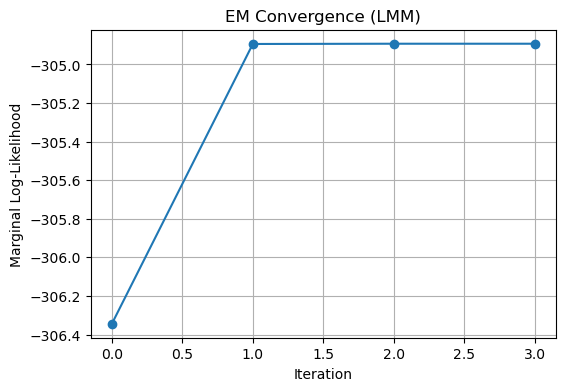

In [19]:
plt.figure(figsize=(6,4))
plt.plot(history["ll"], marker='o')
plt.xlabel("Iteration")
plt.ylabel("Marginal Log-Likelihood")
plt.title("EM Convergence (LMM)")
plt.grid(True)
plt.show()

Check the posterior mean of $\beta$.

In [20]:
print("\nPosterior mean of β (first few entries):")
print(beta_mean[:min(5,p)])

print("\nTrue β (first few entries):")
print(beta_true[:min(5,p)])


Posterior mean of β (first few entries):
[-1.44955654  0.77050568  1.71912188  0.98894637  1.40868547]

True β (first few entries):
[-1.48055571  0.7589416   1.6768389   1.01675352  1.40862415]
